### Construct simple CNN model (1D Convolutional Network)

In [66]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model, regularizers, constraints
from tensorflow.keras.layers import Layer, Input, Embedding, Conv1D, Conv2D, BatchNormalization, ReLU, LeakyReLU, MaxPooling1D, Flatten, Dense, Softmax, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#### Prepare Training Datset

In [2]:
train_5k = pd.read_feather('./../dataset/objs/train_5k.ftr')
test_5k = pd.read_feather('./../dataset/objs/test_5k.ftr')

train_5k, validate_5k = train_test_split(train_5k, train_size = 0.8, random_state=42)

train_X = train_5k['Sequence']
train_y = train_5k['Class']

validate_X = validate_5k['Sequence']
validate_y = validate_5k['Class']

test_X = test_5k['Sequence']
test_y = test_5k['Class']

print(train_5k.head(), '\n') # 80% of train set
print(validate_5k.head(), '\n') # 20% of train set
print(test_5k.head(), '\n') # 100% of test set
print(train_5k.shape, validate_5k.shape, test_5k.shape, sep='\t')

                                                 Sequence        RBP Class
80583   GTCTGCTGTCTCTACACCATCTCCATCATGGGCAATACCACCATCC...   hnRNPC-2     0
11124   AAAAAAAGTTCAAGAGTGTAACTAGTTCACCCCAAGGTAGTGTGTG...     Ago2-1     0
26845   TGAAGATGAGAAACTTCAAGGCAAGATTAACGATGAGGACAAACAG...  eIF4III-1     1
81415   CCCACCCCATCCCAGGTCACCACCTGGCTGAACCCAGGTCCCCGAC...   hnRNPC-2     0
130220  CTGTTCCTATATGCTTCTTAGAATCCTTAAGCCACCTCTCTTGCCT...     TDP-43     0 

                                                 Sequence           RBP Class
58619   GCAGACTTACCATGCCAAAGTGAGCTCTCTTCAGAAGATTCTTTTG...         ESWR1     1
6660    AAATTTGAATAGGAATTGGGTATGAAATCATACAAAGATGATCTAT...    Ago2-MNase     0
42266   GTAGCACCCCGAAGTAGAGCTTTCTGCTCTGCTCCTGGAAAAGGCT...  ELAVL1-MNase     1
142944  CCAGGCGGGGTCAGTGTTGCGCACTGGGGATAGTGCCTCTGCTCGG...         TIAL1     0
119316  ATGTGTAGTCATGGTTTTGATTTTTATTTACACCTTTTGAAATTTG...           QKI     0 

                                            Sequence      RBP Class
0  TTAATTG

In [3]:
set([x for seq in train_X.tolist() for x in seq])

{'A', 'C', 'G', 'N', 'T'}

#### One Hot Encoding & Embedding

In [3]:
# Check bases
bases = ''.join(sorted(set([x for seq in train_X.tolist() for x in seq])))

base_dict = dict((v, k) for (k, v) in dict(enumerate(bases)).items())

train_X_int = [[bases.index(c) for c in seq] for seq in train_X.tolist()]

train_X_onehot = np.eye(len(bases))[train_X_int]

In [5]:
print(bases)
print(train_X_onehot.shape)

ACGNT
(124000, 101, 5)


In [6]:
train_y.head()

80583     0
11124     0
26845     1
81415     0
130220    0
Name: Class, dtype: category
Categories (2, int64): [0, 1]

##### try using only single RBP

In [4]:
train_5k = pd.read_feather('./../dataset/objs/train_5k.ftr')
test_5k = pd.read_feather('./../dataset/objs/test_5k.ftr')

In [5]:
ago_eif_train = train_5k[train_5k['RBP'] == 'Ago-EIF']
ago_eif_test = test_5k[test_5k['RBP'] == 'Ago-EIF']
ago_eif_train.shape

(5000, 3)

In [6]:
train_5k[train_5k['RBP'] == 'Ago-EIF'][:10]

,Sequence,RBP,Class
0,AAGGGGCTAGGATGAGTTTCTGAATCTCCCAAGGGCGAGATTTCGG...,Ago-EIF,0
1,CCTGAAGCAGCAAGTGAGCGGGCTGGAGGGTGTGCAGGACGACCTG...,Ago-EIF,0
2,CACGGCTCCCCCTCGGCCTATTACACGCGTGCGCAGCCAGGCCTCG...,Ago-EIF,0
3,ATACAAGCAGGAGCACATCGCTCTTTTATGAAAGCCCTTCAACATT...,Ago-EIF,0
4,TCCCTTCAAAGGCGACAGACCCAAGCCCACGTCAGGAGAGGAGCGT...,Ago-EIF,0
5,GCTTTGCAACCCTTGTGTTACGGTGCACAGGTGTGCAAAAATTCTC...,Ago-EIF,0
6,TGGGTGATTCCTGAGCAAGCATGCTGCTGTCTCTCTGGCTCTGGGG...,Ago-EIF,0
7,TGCAGACCCCTGCGGCCAGGGCGAGGACGGATCTGAGCAGCTGGGC...,Ago-EIF,0
8,CAGCTGCTGTGGAAAATAGTCTGGCAGTTTCTCAACAATTACACAG...,Ago-EIF,0
9,TTATGGCCAACACTTCCATTTATTTATCAACAGATTCACCCGTGTC...,Ago-EIF,0


In [7]:
#train_X, train_y = train_5k[train_5k['RBP'] == 'Ago-EIF'][:4000]['Sequence'], train_5k[train_5k['RBP'] == 'Ago-EIF'][:4000]['Class']
#valid_X, valid_y = train_5k[train_5k['RBP'] == 'Ago-EIF'][4000:]['Sequence'], train_5k[train_5k['RBP'] == 'Ago-EIF'][4000:]['Class']
train_X, train_y = train_5k[train_5k['RBP'] == 'Ago-EIF']['Sequence'], train_5k[train_5k['RBP'] == 'Ago-EIF']['Class']
test_X, test_y = test_5k[test_5k['RBP'] == 'Ago-EIF']['Sequence'], test_5k[test_5k['RBP'] == 'Ago-EIF']['Class']

train_X_int = [[bases.index(c) for c in seq] for seq in train_X.tolist()]
train_X_onehot = np.eye(len(bases))[train_X_int]

#valid_X_int = [[bases.index(c) for c in seq] for seq in valid_X.tolist()]
#valid_X_onehot = np.eye(len(bases))[valid_X_int]

test_X_int = [[bases.index(c) for c in seq] for seq in test_X.tolist()]
test_X_onehot = np.eye(len(bases))[test_X_int]

#### Model Construction

In [50]:
mymodel_inputs = Input(shape=(101, 5))

x = Conv1D(filters=64, kernel_size=19, strides=1, padding='same')(mymodel_inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling1D(strides=2)(x)
x = Dropout(.1)(x)
x = Conv1D(filters=128, kernel_size=5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling1D(strides=2)(x)
x = Dropout(.1)(x)
x = Flatten()(x)
x = Dense(units=512)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(.5)(x)
x = Dense(units=2)(x)
mymodel_outputs = Softmax()(x)

mymodel = Model(inputs=mymodel_inputs, outputs=mymodel_outputs)

In [51]:
mymodel.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 101, 5)]          0         
                                                                 
 conv1d_17 (Conv1D)          (None, 101, 64)           6144      
                                                                 
 batch_normalization_22 (Bat  (None, 101, 64)          256       
 chNormalization)                                                
                                                                 
 re_lu_10 (ReLU)             (None, 101, 64)           0         
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 50, 64)           0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 50, 64)            0   

In [96]:
mymodel2 = tf.keras.models.Sequential([
    Conv1D(filters=64, kernel_size=19, strides=1, padding='same', input_shape=(101, 5)),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(strides=2),
    Dropout(.1),

    Conv1D(filters=128, kernel_size=5, strides=1, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(strides=2),
    Dropout(.1),

    Flatten(),
    Dense(units=512),
    BatchNormalization(),
    ReLU(),
    Dropout(.5),
    Dense(units=2),
    Softmax()
])

In [97]:
mymodel2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 101, 64)           6144      
                                                                 
 batch_normalization_43 (Bat  (None, 101, 64)          256       
 chNormalization)                                                
                                                                 
 re_lu_31 (ReLU)             (None, 101, 64)           0         
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 50, 64)           0         
 g1D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 50, 64)            0         
                                                                 
 conv1d_32 (Conv1D)          (None, 50, 128)          

In [102]:
mymodel2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='accuracy', patience=20)

In [ ]:
mymodel2.fit(train_X_onehot, train_y, epochs=500, validation_split=0.2)#, callbacks=[early_stopping])

In [21]:
train_X_onehot.shape

(5000, 101, 5)

In [22]:
train_X_onehot_ = train_X_onehot[:, :, :, np.newaxis]
test_X_onehot_ = test_X_onehot[:, :, :, np.newaxis]

In [67]:
# try Conv2D

mymodel3 = tf.keras.Sequential([
    Conv2D(1, (12, 5), padding='same', strides=1, input_shape=(101, 5, 1), kernel_regularizer=regularizers.l1(3e-3), kernel_constraint=constraints.NonNeg()),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [ ]:
mymodel3.summary()

In [68]:
mymodel3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
mymodel3.fit(train_X_onehot_, train_y, epochs=20, validation_split=0.2)

Epoch 1/20
125/125 [==============================] - 3s 19ms/step - loss: 0.8971 - accuracy: 0.5610 - val_loss: 0.5461 - val_accuracy: 0.8000
Epoch 2/20
125/125 [==============================] - 2s 17ms/step - loss: 0.5508 - accuracy: 0.7921 - val_loss: 0.5173 - val_accuracy: 0.8020
Epoch 3/20
125/125 [==============================] - 2s 17ms/step - loss: 0.5274 - accuracy: 0.8002 - val_loss: 0.5170 - val_accuracy: 0.8020
Epoch 4/20
125/125 [==============================] - 2s 18ms/step - loss: 0.5074 - accuracy: 0.8110 - val_loss: 0.5165 - val_accuracy: 0.8020
Epoch 5/20
125/125 [==============================] - 2s 17ms/step - loss: 0.5261 - accuracy: 0.7982 - val_loss: 0.5151 - val_accuracy: 0.8020
Epoch 6/20
125/125 [==============================] - 2s 17ms/step - loss: 0.5317 - accuracy: 0.7894 - val_loss: 0.5132 - val_accuracy: 0.8030
Epoch 7/20
125/125 [==============================] - 2s 17ms/step - loss: 0.5037 - accuracy: 0.8089 - val_loss: 0.5132 - val_accuracy: 0.8020

In [70]:
mymodel3.evaluate(test_X_onehot_, test_y, verbose=2)

32/32 - 0s - loss: 0.4898 - accuracy: 0.8020


[0.48977622389793396, 0.8019999861717224]

In [71]:
weights = mymodel3.get_weights()
pd.DataFrame(np.squeeze(weights[0]).transpose())

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.019776,0.045333,0.116666,0.031920,0.069304,0.113596,0.073846,0.000751,0.124491,0.020391,0.077292,0.048665
1,0.033477,0.013957,0.130316,0.059557,-0.000000,0.059165,0.116853,0.003607,0.075237,0.004112,-0.000000,0.067742
2,0.000389,0.000184,-0.000000,-0.000000,-0.000000,0.049192,0.001444,-0.000000,-0.000000,-0.000000,-0.000000,0.001475
3,-0.000000,0.049463,0.081515,0.085805,0.004616,-0.000000,0.014204,0.016685,0.019458,0.117020,0.005925,0.061661
4,0.039192,0.051192,0.134347,0.003186,0.107606,0.105038,0.199502,0.076131,0.004299,0.041348,0.032253,0.114201


In [85]:
test = pd.DataFrame(np.squeeze(weights[0]).transpose())

In [86]:
test += 0.001
test = test / test.sum(axis=0)

In [83]:
test.sum(axis=0)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
dtype: float32

In [92]:
test.index = sorted(list('ACGTN'))

In [98]:
test = test.transpose()
test['-'] = 0

In [99]:
test

,A,C,G,N,T,-
0,0.212363,0.352400,0.014195,0.010221,0.410820,0
1,0.280587,0.090577,0.007171,0.305597,0.316068,0
2,0.251507,0.280683,0.002137,0.176374,0.289299,0
3,0.177495,0.326510,0.005392,0.468032,0.022572,0
4,0.376913,0.005361,0.005361,0.030110,0.582254,0
5,0.345178,0.181224,0.151185,0.003012,0.319401,0
6,0.182175,0.286852,0.005948,0.037006,0.488019,0
7,0.017136,0.045089,0.009787,0.173090,0.754897,0
8,0.549232,0.333663,0.004377,0.089538,0.023191,0
9,0.113861,0.027211,0.005323,0.628196,0.225409,0


In [102]:
import seqlogo

test1 = seqlogo.CompletePm(pfm = test.transpose(), background = 0.25, alphabet_type = "reduced DNA")

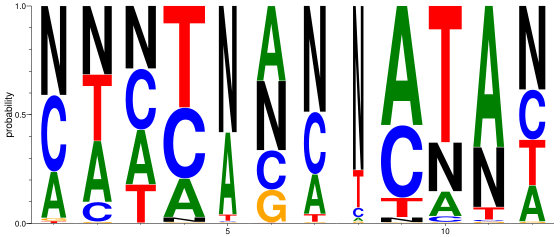

In [108]:
seqlogo.seqlogo(test1, ic_scale=False, size='large')